# AGRUPAMENTOS DE CONSUMO DE ENERGIA DE CLIENTES

## Objetivos

O objetivo desse projeto é, através de dados sobre consumo de energia de alguns clientes e agrupá-los por características similares, para podermos entender seus comportamentos, através de uma base de dados obtida no **UCI Machine Learninrg Repository**, com dados coletados por um período de aproximadamente 4 anos, demonstrados no **dicionário de dados**.

## Técnicas utilizadas

Além das análises gráficas, colocaremos em prática:
- Aprendizagem não supervisionada
- Análise Exploratória de Dados
- Tratamento dos dados 
- PCA
- Curva de Elbow
- Distância Eudliciana
- Cluterização
- Máquinas Preditivas
- Coeficiente de Silhueta

## Pode-se usar também para:

- Definir nível de consumo
- Descobrir as causas de um consumo acentuado
- Se tais consumidores possuem aparelhos mais antigos
- Se possuem muitos dispositivos elétricos (itens de luxo)
- Implementar taxas adaptativas (renda, por exemplo)
- Entender e estimular consumo de energia em grupos
- Verificar possíveis erros na distribuição ou transmissão de energia

## Dicionário de Dados

1. **data**: Data no formato dd / mm / aaaa
2. **hora**: hora no formato hh: mm: ss
3. **global_active_power**: potência ativa média global por minuto (em quilowatt)
4. **potência reativa global da família**: potência reativa média global por minuto (em quilowatt)
5. **voltagem**: tensão média por minuto (em volt)
6. **intensidade global**: intensidade de corrente média por minuto global doméstica (em ampere)
7. **sub_metering_1**: submedição de energia nº 1 (em watt-hora de energia ativa ) Corresponde à **cozinha**, que contém essencialmente uma máquina de lavar louça, um forno e um micro-ondas (a placa eléctrica não é eléctrica mas sim a gás).
8. **sub_metering_2**: sub-medição de energia nº 2 (em watt-hora de energia ativa). Corresponde à **lavanderia**, contendo uma máquina de lavar, uma secadora, uma geladeira e uma luz.
9. **sub_metering_3**: submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um **aquecedor elétrico de água e um ar condicionado**.

##### Fonte de Dados

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

## 1 Base de dados e Bibliotecas

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Base de dados
dataset = pd.read_csv('household_power_consumption.txt', delimiter = ';', low_memory = False)

## 2 Análise Exploratória dos Dados

In [3]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Dimensões
dataset.shape

(2075259, 9)

In [5]:
# Tipos dos dados
dataset.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

> Os tipos das variáveis necessitam modificações
- Data > verificar se será necessário conversão para Datetime, bem como 'Time'
- O restante das variáveis estão como **object**, exceto a última que está como float
- Será necessária uma normalização

In [6]:
# Procurando valores missing
dataset.isnull().values.any()

True

In [7]:
# Procurando em quais colunas estão
dataset.isnull().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Percentual de valores missing

In [8]:
sum_null = dataset['Sub_metering_3'].isnull().sum()

In [9]:
perc_null = round(sum_null/len(dataset), 2)

In [10]:
print(f'Percentual de valores nulos: {perc_null}%')

Percentual de valores nulos: 0.01%


## 3 Pré-Processamento dos Dados

> Decidimos:
- como o número de dados missing é ínfimo (0.01%), faremos o drop destes
- as 2 primeiras variáveis (Date e Time) não são relevantes para o nosso objetivo, portanto faremos a exclusão das colunas e com uma linha só de comando, eliminaremos os NaN

In [11]:
dataset = dataset.iloc[0:, 2:9].dropna()

In [12]:
# Resultado de exclusão das colunas
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [13]:
# Resultado da exclusão de NaN
dataset.isnull().values.any()

False

In [14]:
# Verificando nulos
dataset.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

> ATENÇÃO: 
- Como estamos trabalhando com aprendizagem não supervisionada, o nosso 'Y' não existe e o 'X' (variáveis de entrada), são as variáveis existentes no dataset
- O cluster (agrupamento) será o nosso "Y"
- Usamos os argumento 'values' em dataset.values por ele já nos retornar um array com os valores

In [15]:
# Criando uma variável com os valores em formato formato de array (values)
dataset_atrib = dataset.values

In [16]:
# Visualizando as variáveis de entradas 
dataset_atrib

array([['4.216', '0.418', '234.840', ..., '0.000', '1.000', 17.0],
       ['5.360', '0.436', '233.630', ..., '0.000', '1.000', 16.0],
       ['5.374', '0.498', '233.290', ..., '0.000', '2.000', 17.0],
       ...,
       ['0.938', '0.000', '239.820', ..., '0.000', '0.000', 0.0],
       ['0.934', '0.000', '239.700', ..., '0.000', '0.000', 0.0],
       ['0.932', '0.000', '239.550', ..., '0.000', '0.000', 0.0]],
      dtype=object)

> Como a massa de dados é gigantesca e poderá causar problemas de desempenho, utilizaremos uma amostra (1%) pequena para treinar nossa máquina

In [17]:
# Amostra de 1%
# Dataset contém a amostra e Amostra contém o restante
dataset, amostra2 = train_test_split(dataset_atrib, train_size = .01)

In [18]:
amostra2.shape

(2028788, 7)

In [19]:
dataset.shape

(20492, 7)

## 4 Máquina Preditiva Segmentação de Clientes

> INSIGHT:
- Usaremos o **PCA (Principal Component Analysis)** que é uma técnica de aprendizagem não supervisionada para reduzir a dimensão da massa de dados.
- **Lógica:** Transformamos as 7 variáveis em 2 variáveis (ou 2 componentes principais), ou seja, **juntamos** as variáveis de acordo com as semelhança(obtida pela Variância) entre eles

In [20]:
# Reduzindo a dimensionalidade de 7 para 2 (n_components)
pca = PCA(n_components = 2).fit_transform(dataset)

> Usando o algoritmo **Kmeans** para criar os grupos (segmentos) dos clientes levando-se em conta os seguintes critérios:

Funionamento: agrupá-los em diferentes grupos com base em suas características semelhantes.

1. Inicialização: São escolhidos K pontos iniciais como centróides, que podem ser escolhidos aleatoriamente ou com algum critério específico

2. Atribuição: Cada ponto de dados é atribuído ao centróide mais próximo com base na **distância Euclidiana**, criando K grupos iniciais

3. Atualização: Os centróides são recalculados como a média dos pontos de dados atribuídos a eles, o que atualiza a posição dos centróides

4. Repetição: Os passos 2 e 3 são repetidos até que ocorra uma convergência, ou seja, até que **não haja mais alterações significativas** nos centróides ou que o número máximo de iterações seja atingido

5. Resultado: No final, obtemos K clusters, onde cada ponto de dados pertence a um cluster específico com base na atribuição aos centróides

> Usaremos uma técnica para testarmos o 'K' de 1 até 12 (nada mais nada menos, são 12 máquinas preditivas criadas)

In [21]:
# Determinando um range do Hyperparâmetro "K" do Kmeans
k_range = range(1,12)
k_range

range(1, 12)

In [22]:
# Aplicando o modelo K-Means para cada valor de K (k_range)
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]
# Lógica: Criamos o KMeans e passamos como parâmetro o número de clusters (k, que é quantidade de clusters que queremos criar, 12) fazemos o fit de cada k

> Seguimos os seguintes preceitos:

1. O agrupamento guiado pelo princípio de que os itens dentro de um cluster devem ser **muito** similares entre si, mas **muito** diferentes entre clusters
2. Segmentação de clientes em grupos com demografia semelhante ou padrões de compra para campanhas de marketing direcionadas
3. Simplificação de grandes conjuntos de dados agrupando características com valores semelhantes em um número menor de categorias homogêneas
* Se você começar com dados sem rótulo ou seja sem variável target, você pode usar o clustering para criar rótulos de classe. A partir daí, você pode aplicar um algoritmo supervisionado, como árvores de decisão para encontrar os preditores mais importantes dessas classes!

* A qualidade do agrupamento depende do algoritmo escolhido, da função de distância e da aplicação. Diz-se que a qualidade de um modelo de cluster é superior, quando a distância inter-cluster é maximizada e a distância intra-cluster é minimizada

* Às vezes, o número de clusters é definido por requisitos de negócios ou a motivação para a análise. 

* Muito provavelmente, você terá um conhecimento a priori sobre os verdadeiros agrupamentos e você pode aplicar essa informação para escolher o número de clusters. (Ex: cliente bom/cliente médio/ cliente ruim   etc...

### Curva de Elbow

> O que é:

- A curva de Elbow (cotovelo) é um gráfico utilizado para determinar o número ideal de clusters em uma análise de agrupamento (clustering). O objetivo é identificar o ponto de inflexão na curva, conhecido como "cotovelo", que indica o número ideal de clusters para o conjunto de dados.

> INSIGHT:

- Quanto mais variância você consegue explicar, melhor é conhecimento dos dados e vice-versa



In [23]:
# Ajustando o centróide dos clusters para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

> Após a execução do algoritmo K-means, os centros dos clusters encontrados são armazenados no atributo "cluster_centers_"

In [24]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids] 
dist = [np.min(ke, axis = 1) for ke in k_euclid] 
# np.min[] retorna o valor mínimo de cada linda de ke

> 'cdist' é uma função do SciPy usada para calcular a distância entre pontos em dois conjuntos de dados

In [26]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

> Essa métrica é utilizada para avaliar o quão compactos estão os pontos dentro de cada cluster em um algoritmo de agrupamento

In [27]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [29]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Cada Valor de K')

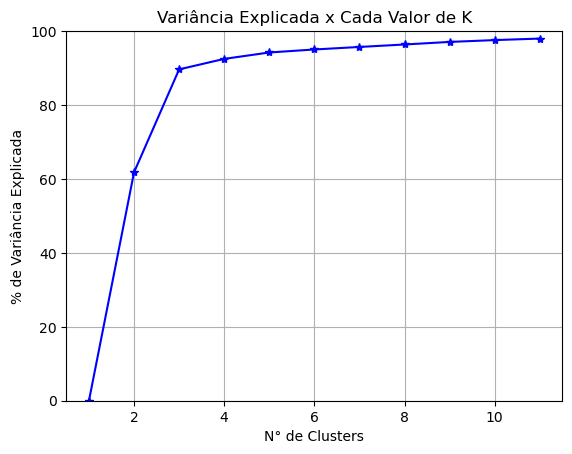

In [30]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('N° de Clusters')
plt.ylabel('% de Variância Explicada')
plt.title('Variância Explicada x Cada Valor de K')

>INSGHT: 

- A curva de Elbow nos mostrou que um número de clusters maior do que 8 é o ideal 

Escolhendo um Valor de K inicial **> ou = 8** para avaliação da Máquina Preditiva

In [31]:
# Criando um modelo com K = 8 clusters
modelo_v1 = KMeans(n_clusters = 8)
modelo_v1.fit(pca)

KMeans()

## 5 Avaliação da Máquina Preditiva

#### 5.1 Avaliando a Máquina Preditiva com k=8

In [33]:
# Nessas linhas, estão sendo calculados os valores mínimos e máximos para os eixos x e y do gráfico
# E assim definir os limites do gráfico para a área que será plotada
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5

In [34]:
# Aqui, está sendo criada uma grade retangular para representar os pontos do gráfico com meshgrid (matriz bidimensional)
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02)) #  sequência de valores, com um passo de 0.02, que serão usados para preencher a grade

In [35]:
# Aqui fazemos as previsões para cada ponto da grade
# Os valores dos pontos da grade são "achatados" usando a função ravel() e concatenados ao longo do segundo eixo usando np.c_
# Em seguida, as previsões são obtidas chamando o método predict() do modelo modelo_v1
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])

In [37]:
# Aqui, o resultado das previsões é ajustado para a forma da grade original
# O objetivo é garantir que a forma de Z corresponda à forma de xx
Z = Z.reshape(xx.shape)

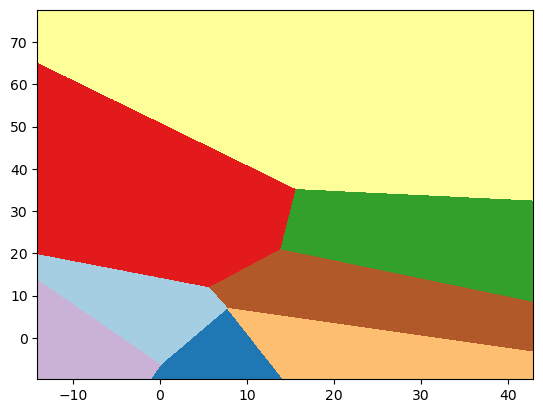

In [38]:
# Plot das áreas dos clusters usando um mashgrid para melhor visualizar os clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

In [39]:
# Silhouette Score
# Calcula o coeficiente de silhueta de um modelo de agrupamento
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6217814700453993

> SOBRE O COEFICIENTE DE SILHUETA

- A função silhouette_score calcula o coeficiente de silhueta, uma medida de qualidade de agrupamento que avalia o quão bem os pontos estão agrupados. O coeficiente de silhueta varia de -1 a 1, em que valores mais próximos de 1 indicam que as amostras estão bem separadas em relação aos clusters, valores próximos de 0 indicam sobreposição entre clusters e valores próximos de -1 indicam que as amostras foram atribuídas aos clusters errados.

#### 5.2 Avaliando a Máquina Preditiva com K=9

In [40]:
# Criando um modelo com K = 9
modelo_v2 = KMeans(n_clusters = 9)
modelo_v2.fit(pca)

KMeans(n_clusters=9)

In [41]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6473009742412332

#### 5.3 Avaliando a Máquina Preditiva com K=10

In [43]:
# Criando um modelo com K = 10
modelo_v2 = KMeans(n_clusters = 10)
modelo_v2.fit(pca)

KMeans(n_clusters=10)

In [44]:
# Silhouette Score
labels = modelo_v2.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6589774638483199

#### 5.4 Avaliando a Máquina Preditiva com K=11

In [45]:
# Criando um modelo com K = 11
modelo_v3 = KMeans(n_clusters = 11)
modelo_v3.fit(pca)

KMeans(n_clusters=11)

In [46]:
# Silhouette Score
labels = modelo_v3.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.6158900205130803

## 6 Construindo a Máquina Preditiva com o uso da Marcação dos Clusters



> Aqui mostraremos o cluster que cada cliente pertence

In [51]:
# Criando uma lista com nomes das colunas
names = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [53]:
# Incluindo o n° do cluster na base de clientes
cluster_map = pd.DataFrame(dataset, columns = names)
cluster_map['Global_active_power'] = pd.to_numeric(cluster_map['Global_active_power']) # transformando os 'objects' em 'numeric'
cluster_map['cluster'] = modelo_v2.labels_ # criamos uma colunas com o target

In [54]:
cluster_map

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,cluster
0,0.900,0.000,238.440,3.800,1.000,0.000,1.0,1
1,0.786,0.086,246.050,3.200,0.000,0.000,1.0,5
2,0.424,0.234,243.850,2.000,0.000,0.000,0.0,5
3,0.458,0.116,241.210,2.000,0.000,4.000,1.0,1
4,0.416,0.210,242.230,2.000,0.000,0.000,0.0,5
...,...,...,...,...,...,...,...,...
20487,0.392,0.182,240.360,1.800,0.000,1.000,0.0,5
20488,1.562,0.204,242.340,6.400,1.000,0.000,0.0,1
20489,1.590,0.330,237.450,6.800,0.000,1.000,17.0,2
20490,1.312,0.078,242.280,5.400,0.000,0.000,19.0,2


In [57]:
# Calculando a média de consumo de energia por cluster
cluster_map.groupby('cluster')['Global_active_power'].mean()

cluster
0    3.238219
1    1.467619
2    1.813850
3    3.215258
4    4.289511
5    0.358008
6    5.956625
7    1.124485
8    2.348053
9    2.147083
Name: Global_active_power, dtype: float64

# Fim